In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad

from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/data/POL/HALOB/hydro/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars")

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
len(myhalo.gs.mass)

47660894

In [5]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)

density [-0.05960974 -1.06715898 -1.40904299]


In [6]:
myhalo.r_virial(600,n=4)

starting
stackted
start histogram
 done
rotated
| r_200 = 166.9921875
| Diagonal matrix computed 
|    |19, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 2|


In [7]:
pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st))#, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass))#,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v))#,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

17162877 17162877


In [8]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhalo.p.G)

<IPython.core.display.Javascript object>


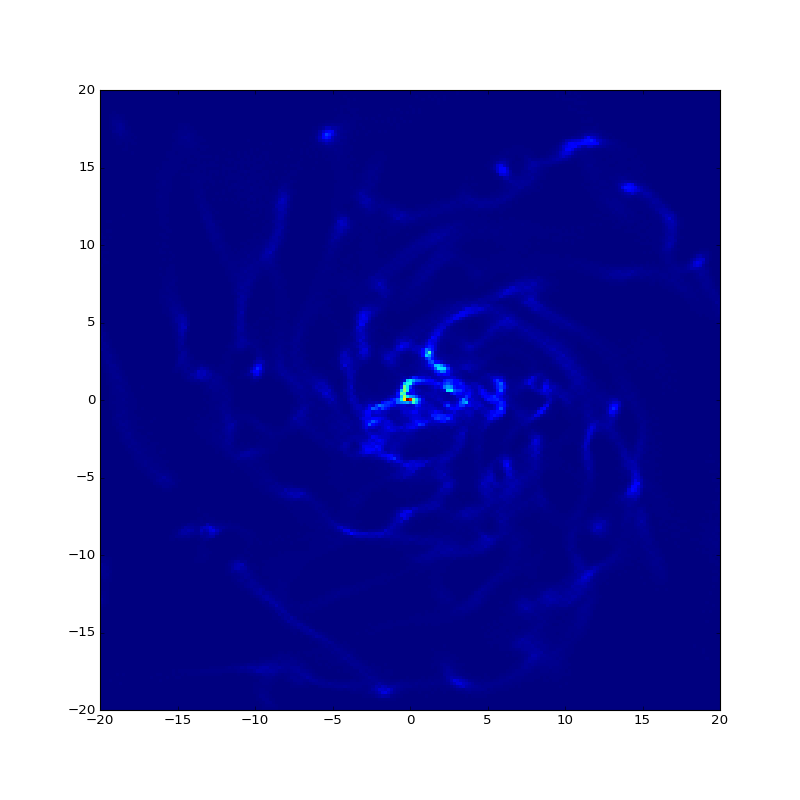

In [9]:
edges = np.linspace(-20,20,200)
H, xedges, yedges = np.histogram2d(myhalo.gs.pos3d[:,0], myhalo.gs.pos3d[:,1],
                                   bins=(edges, edges),weights=myhalo.gs.mass)
H = H.T
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.imshow(H, interpolation='nearest', origin='low',
          extent=[edges[0], edges[-1], edges[0], edges[-1]])

In [10]:
edges = np.linspace(-20,20,100)
H, xedges, yedges = np.histogram2d(myhalo.gs.pos3d[:,0], myhalo.gs.pos3d[:,2],
                                   bins=(edges, edges),weights=myhalo.gs.temp/coco/myhalo.gs.rho)
H = H.T
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.imshow(H, interpolation='nearest', origin='low',
          extent=[edges[0], edges[-1], edges[0], edges[-1]])

NameError: name 'coco' is not defined

In [10]:
print H


[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


In [30]:
coco = myhalo.p.mu * (myhalo.p.simutokms**2) * myhalo.p.cmtopc * 1e4 / myhalo.p.kB

In [23]:
print myhalo.gs.temp.max()

4.27547e+25


In [13]:
myhalo.p.kpctokm

3.086e+16

# virial ratio q

In [11]:
inside_halo = np.where(r2<(myhalo.r200)**2)
kmtokpc = 1 / 3.08567758128e+16 
q = (np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo])) + 1 

In [12]:
print "q = ",q,r", numerator = ",np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2),", denominator = ",np.sum(mass[inside_halo]*Phy[inside_halo])
print "ratio = ",(np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo]))

q =  -0.030208254560523118 , numerator =  3.42184497516139e-17 , denominator =  -3.321508e-17
ratio =  -1.0302082545605231


In [23]:
dm = len(myhalo.dm.mass)+len(myhalo.st.mass)
inside_halo = np.where(r2[:dm]<(myhalo.r200)**2)
kmtokpc = 1 / 3.08567758128e+16 
q = (np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo])) + 1 

In [24]:
print "q = ",q,r", numerator = ",np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2),", denominator = ",np.sum(mass[inside_halo]*Phy[inside_halo])
print "ratio = ",(np.sum(mass[inside_halo]*(v[inside_halo]*kmtokpc)**2) / np.sum(mass[inside_halo]*Phy[inside_halo]))

q =  0.0731534619874 , numerator =  3.42184464146e-17 , denominator =  -3.69192e-17
ratio =  -0.926846538013


# cheating with YT

In [5]:
import yt


In [6]:
co = yt.load("/data/POL/HALOB/output_00417/info_00417.txt")

yt : [INFO     ] 2017-07-18 15:58:15,917 Parameters: current_time              = 0.986596082171
yt : [INFO     ] 2017-07-18 15:58:15,917 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2017-07-18 15:58:15,918 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-18 15:58:15,920 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-07-18 15:58:15,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-18 15:58:15,923 Parameters: current_redshift          = -5.79180090199e-05
yt : [INFO     ] 2017-07-18 15:58:15,924 Parameters: omega_lambda              = 0.723999977112
yt : [INFO     ] 2017-07-18 15:58:15,925 Parameters: omega_matter              = 0.275999993086
yt : [INFO     ] 2017-07-18 15:58:15,925 Parameters: hubble_constant           = 0.703000030518


In [7]:
data = co.all_data()

In [8]:
myhalo.gs.temp

array([  6.06224254e+21,   5.99483041e+21,   3.30064989e+21, ...,
         1.16192078e+23,   1.16554446e+23,   1.17537663e+23], dtype=float32)

In [9]:
co.field_list

[('all', 'particle_age'),
 ('all', 'particle_identifier'),
 ('all', 'particle_mass'),
 ('all', 'particle_metallicity'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_refinement_level'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('io', 'particle_age'),
 ('io', 'particle_identifier'),
 ('io', 'particle_mass'),
 ('io', 'particle_metallicity'),
 ('io', 'particle_position_x'),
 ('io', 'particle_position_y'),
 ('io', 'particle_position_z'),
 ('io', 'particle_refinement_level'),
 ('io', 'particle_velocity_x'),
 ('io', 'particle_velocity_y'),
 ('io', 'particle_velocity_z'),
 ('ramses', 'Density'),
 ('ramses', 'Metallicity'),
 ('ramses', 'Pressure'),
 ('ramses', 'var6'),
 ('ramses', 'var7'),
 ('ramses', 'x-velocity'),
 ('ramses', 'y-velocity'),
 ('ramses', 'z-velocity')]

In [36]:
x ,y, z = data['ramses','x-velocity'], data['ramses','y-velocity'],data['ramses','z-velocity']
mass = data['all', 'particle_mass'].in_units('Msun')

In [11]:
pressure = data['ramses', 'Pressure']

In [12]:
density = data['ramses','Density']

In [24]:
alls, counts_all = np.unique(mass, return_counts=True)

In [25]:
io, counts_io = np.unique(data['io', 'particle_mass'].in_units('Msun'),return_counts=True)

In [46]:
print data['ramses', 'var6']

[  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
   9.50726241e-285   2.29055651e-284   2.56765028e-284] dimensionless


In [45]:
print x.min(),x.max()

-0.705829717476 code_velocity 0.711129748593 code_velocity


In [ ]:
edges = np.linspace(x.min(),myhalo.gs.pos3d[:,0].max(),400)
H, xedges, yedges = np.histogram2d(myhalo.gs.pos3d[:,0], myhalo.gs.pos3d[:,1],
                                   bins=(edges, edges),weights=myhalo.gs.mass)
H = H.T
fig,ax = plt.subplots(figsize=[10,10])
#ax.set_xlim([-20,20])
#ax.set_ylim([-20,20])
ax.imshow(H, interpolation='nearest', origin='low',
          extent=[edges[0], edges[-1], edges[0], edges[-1]])

<IPython.core.display.Javascript object>


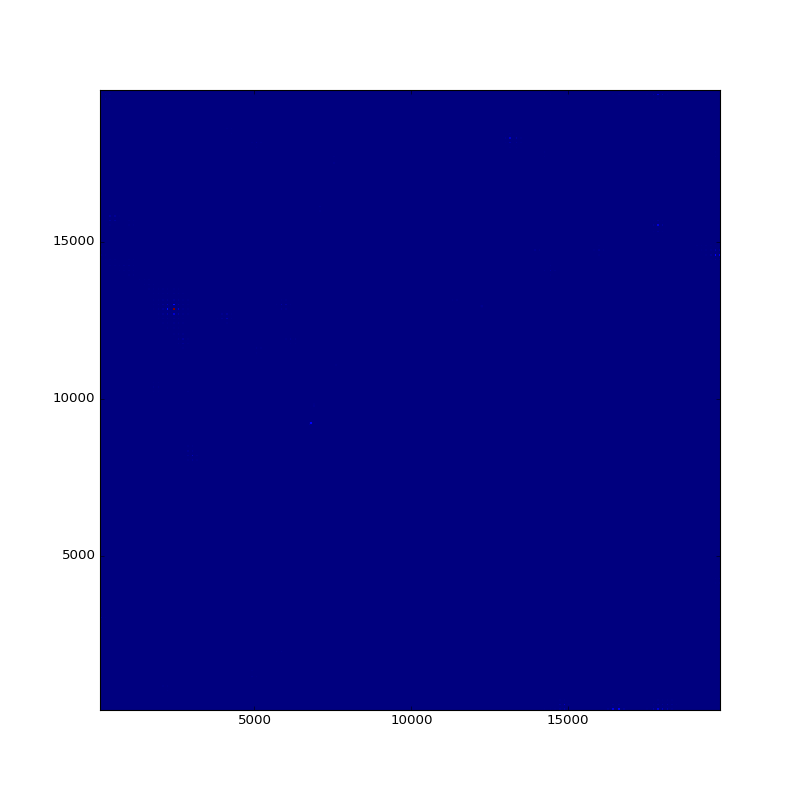

In [44]:
edges = np.linspace(myhalo.gs.pos3d[:,0].min(),myhalo.gs.pos3d[:,0].max(),400)
H, xedges, yedges = np.histogram2d(myhalo.gs.pos3d[:,0], myhalo.gs.pos3d[:,1],
                                   bins=(edges, edges),weights=myhalo.gs.mass)
H = H.T
fig,ax = plt.subplots(figsize=[10,10])
#ax.set_xlim([-20,20])
#ax.set_ylim([-20,20])
ax.imshow(H, interpolation='nearest', origin='low',
          extent=[edges[0], edges[-1], edges[0], edges[-1]])

In [34]:
counts_io - counts_all

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])